# T1/T2 MRI CycleGAN s U-Net Generatorima

Ova bilježnica implementira CycleGAN model za transformaciju između T1 i T2 MRI snimaka. Koristi U-Net arhitekturu za generatore kako bi se postigli bolji rezultati u očuvanju strukture.

In [1]:
!nvidia-smi


Thu May  8 13:18:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   29C    P5             18W /   80W |     469MiB /   6144MiB |     57%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Postavljanje okruženja i uvoz bibliteka

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch.backends.cudnn as cudnn
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import datetime
import json

# Postavljanje random seed-a za reproducibilnost
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    # Omogućavanje CUDNN benchmarkinga za brže treniranje
    cudnn.benchmark = True
# Provjera dostupnosti GPU-a
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Koristim uređaj: {device}")
# Ako je dostupan CUDA, ispiši informacije o GPU-u
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memorija: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Koristim uređaj: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memorija: 6.19 GB


In [25]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from utils.models import UNetGenerator
from utils.config import CycleGANConfig
from utils.dataset import get_stratified_data_loaders
from utils.train import train_cyclegan
from utils.test import test_model
from utils.visualization import visualize_results, plot_training_curves


In [18]:
config = CycleGANConfig(
    t1_dir="../dataset/data/images/t1",  # Prilagodite putanju prema vašim podacima
    t2_dir="../dataset/data/images/t2",  # Prilagodite putanju prema vašim podacima
    results_dir="../rezultati/standard_model",
    checkpoints_dir="../checkpoints/standard_model",
    batch_size=4,  # Smanjite za manje GPU memorije
    lr=0.0002,
    beta1=0.5,
    beta2=0.999,
    n_epochs=250,  # Prilagodite broj epoha prema potrebi
    decay_epoch=125,  # Learning rate počinje opadati nakon ove epohe
    img_size=256,
    input_channels=1,  # MRI slike su sive (1 kanal)
    output_channels=1,
    ngf=64,  # Broj filtera u generatoru
    ndf=64,  # Broj filtera u diskriminatoru
    lambda_A=10.0,  # Težina cycle loss-a za T1->T2->T1
    lambda_B=10.0,  # Težina cycle loss-a za T2->T1->T2
    lambda_identity=0.5,  # Težina identity loss-a
    architecture="standard",  # Koristimo standardnu arhitekturu
    sample_interval=50,  # Vizualiziraj slike svakih 5 epoha
    checkpoint_interval=50,  # Spremi checkpoint svakih 10 epoha
    device=None  # Automatski odabir (GPU ako je dostupan, inače CPU)
)

In [19]:
# Ispiši konfiguraciju
config.print_config()


=== Konfiguracija modela ===
Arhitektura: standard
T1 direktorij: ../dataset/data/images/t1
T2 direktorij: ../dataset/data/images/t2
Batch veličina: 4
Learning rate: 0.0002
Broj epoha: 250
Veličina slike: 256x256
Broj filtera u generatoru: 64
Broj filtera u diskriminatoru: 64
Lambda A: 10.0
Lambda B: 10.0
Lambda identity: 0.5
Uređaj: cuda



In [20]:
# Lista posebnih ID-ova za stratificiranu podjelu (ID-ovi "mutnijih" slika)
special_ids = [
    '035', '230', '231', '232', '233', '234', '238', '290', '291', '292', 
    '293', '294', '303', '305', '306', '307', '310', '314', '315', '322', 
    '331', '332', '333', '337', '340', '345', '347', '371', '372', '373', 
    '378', '382', '388', '395', '423', '424', '425', '426', '427', '430', 
    '433', '434', '435', '442', '462', '463', '464', '469', '470', '473', 
    '474', '475', '476', '477', '478', '510', '517', '532', '541', '542', 
    '543', '547', '548', '553', '561', '563', '571', '573', '574', '588', 
    '595', '596', '597'
]

print(f"Broj posebnih ID-ova: {len(special_ids)}")

train_dataloader, val_dataloader, test_dataloader = get_stratified_data_loaders(
    config=config,
    special_ids=special_ids,
    train_ratio=0.8,
    val_ratio=0.05,
    test_ratio=0.15
)

Broj posebnih ID-ova: 73
Pronađeno 572 T1 slika i 572 T2 slika
Pronađeno 572 sparenih T1/T2 slika
Pronađeno 69 posebnih slika i 503 regularnih slika.
Podjela posebnih slika: 55 trening, 3 validacija, 11 test
Podjela regularnih slika: 402 trening, 25 validacija, 76 test
Ukupna podjela: 457 trening, 28 validacija, 87 test


In [21]:
G_AB, G_BA, train_history, best_val_loss = train_cyclegan(
    config=config,
    use_test_split=True,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader
)

Epoha 1/250: 100%|██████████| 115/115 [00:34<00:00,  3.30it/s, D_A_loss=0.3334, D_B_loss=0.2569, G_loss=2.5864]


Epoha 1/250 - Train gubici: G: 8.7984, D_A: 0.4486, D_B: 0.5757 | Val gubici: G: 2.1517, Cycle: 1.4950
Novi najbolji validacijski gubitak: 1.4950, spremam modele...


Epoha 2/250: 100%|██████████| 115/115 [00:32<00:00,  3.57it/s, D_A_loss=0.1865, D_B_loss=0.2793, G_loss=2.2248]


Epoha 2/250 - Train gubici: G: 2.5073, D_A: 0.2474, D_B: 0.1990 | Val gubici: G: 1.7472, Cycle: 1.0478
Novi najbolji validacijski gubitak: 1.0478, spremam modele...


Epoha 3/250: 100%|██████████| 115/115 [00:31<00:00,  3.60it/s, D_A_loss=0.2330, D_B_loss=0.2071, G_loss=2.4384]


Epoha 3/250 - Train gubici: G: 2.0646, D_A: 0.2556, D_B: 0.2371 | Val gubici: G: 1.7872, Cycle: 1.1041


Epoha 4/250: 100%|██████████| 115/115 [00:32<00:00,  3.58it/s, D_A_loss=0.2890, D_B_loss=0.3161, G_loss=1.7313]


Epoha 4/250 - Train gubici: G: 1.9001, D_A: 0.2533, D_B: 0.2427 | Val gubici: G: 1.6798, Cycle: 0.8956
Novi najbolji validacijski gubitak: 0.8956, spremam modele...


Epoha 5/250: 100%|██████████| 115/115 [00:32<00:00,  3.59it/s, D_A_loss=0.2031, D_B_loss=0.2754, G_loss=1.5198]


Epoha 5/250 - Train gubici: G: 1.8068, D_A: 0.2550, D_B: 0.2395 | Val gubici: G: 1.5219, Cycle: 0.9242


Epoha 6/250: 100%|██████████| 115/115 [00:30<00:00,  3.78it/s, D_A_loss=0.2377, D_B_loss=0.2602, G_loss=1.5873]


Epoha 6/250 - Train gubici: G: 1.7491, D_A: 0.2551, D_B: 0.2490 | Val gubici: G: 1.6613, Cycle: 0.7746
Novi najbolji validacijski gubitak: 0.7746, spremam modele...


Epoha 7/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2128, D_B_loss=0.2243, G_loss=1.6057]


Epoha 7/250 - Train gubici: G: 1.6949, D_A: 0.2528, D_B: 0.2415 | Val gubici: G: 1.4058, Cycle: 0.8487


Epoha 8/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2458, D_B_loss=0.2749, G_loss=1.6348]


Epoha 8/250 - Train gubici: G: 1.6769, D_A: 0.2658, D_B: 0.2458 | Val gubici: G: 1.4149, Cycle: 0.8109


Epoha 9/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2235, D_B_loss=0.1607, G_loss=1.4631]


Epoha 9/250 - Train gubici: G: 1.5966, D_A: 0.2480, D_B: 0.2347 | Val gubici: G: 1.8469, Cycle: 0.9812


Epoha 10/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1986, D_B_loss=0.1794, G_loss=1.3785]


Epoha 10/250 - Train gubici: G: 1.5973, D_A: 0.2756, D_B: 0.2397 | Val gubici: G: 1.4266, Cycle: 0.7767


Epoha 11/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1976, D_B_loss=0.2797, G_loss=1.2970]


Epoha 11/250 - Train gubici: G: 1.5491, D_A: 0.2464, D_B: 0.2356 | Val gubici: G: 1.2532, Cycle: 0.7842


Epoha 12/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2297, D_B_loss=0.1586, G_loss=1.3774]


Epoha 12/250 - Train gubici: G: 1.5272, D_A: 0.2881, D_B: 0.2240 | Val gubici: G: 1.1222, Cycle: 0.6076
Novi najbolji validacijski gubitak: 0.6076, spremam modele...


Epoha 13/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2110, D_B_loss=0.2470, G_loss=1.5003]


Epoha 13/250 - Train gubici: G: 1.4850, D_A: 0.2414, D_B: 0.2329 | Val gubici: G: 1.3956, Cycle: 0.8263


Epoha 14/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1930, D_B_loss=0.2263, G_loss=1.2571]


Epoha 14/250 - Train gubici: G: 1.5172, D_A: 0.2484, D_B: 0.2190 | Val gubici: G: 1.3422, Cycle: 0.6287


Epoha 15/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2067, D_B_loss=0.1399, G_loss=1.2277]


Epoha 15/250 - Train gubici: G: 1.4852, D_A: 0.2572, D_B: 0.2220 | Val gubici: G: 1.0709, Cycle: 0.6410


Epoha 16/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2095, D_B_loss=0.1968, G_loss=1.5761]


Epoha 16/250 - Train gubici: G: 1.4869, D_A: 0.2578, D_B: 0.2158 | Val gubici: G: 1.3004, Cycle: 0.6907


Epoha 17/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2402, D_B_loss=0.2393, G_loss=1.2576]


Epoha 17/250 - Train gubici: G: 1.5151, D_A: 0.2476, D_B: 0.2043 | Val gubici: G: 1.6359, Cycle: 0.7768


Epoha 18/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2050, D_B_loss=0.1953, G_loss=1.3276]


Epoha 18/250 - Train gubici: G: 1.4778, D_A: 0.2777, D_B: 0.2063 | Val gubici: G: 1.6771, Cycle: 0.7492


Epoha 19/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2449, D_B_loss=0.3851, G_loss=1.1414]


Epoha 19/250 - Train gubici: G: 1.4755, D_A: 0.2498, D_B: 0.2162 | Val gubici: G: 1.2520, Cycle: 0.6312


Epoha 20/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1855, D_B_loss=0.1191, G_loss=1.3645]


Epoha 20/250 - Train gubici: G: 1.4588, D_A: 0.2488, D_B: 0.2275 | Val gubici: G: 1.2313, Cycle: 0.7861


Epoha 21/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2275, D_B_loss=0.2130, G_loss=1.6462]


Epoha 21/250 - Train gubici: G: 1.4416, D_A: 0.2457, D_B: 0.2119 | Val gubici: G: 1.1127, Cycle: 0.7178


Epoha 22/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2204, D_B_loss=0.1977, G_loss=1.4034]


Epoha 22/250 - Train gubici: G: 1.4217, D_A: 0.2469, D_B: 0.2155 | Val gubici: G: 1.4427, Cycle: 0.7824


Epoha 23/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2375, D_B_loss=0.1924, G_loss=1.2856]


Epoha 23/250 - Train gubici: G: 1.4070, D_A: 0.2508, D_B: 0.2230 | Val gubici: G: 1.2479, Cycle: 0.6813


Epoha 24/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1675, D_B_loss=0.4316, G_loss=1.2306]


Epoha 24/250 - Train gubici: G: 1.4123, D_A: 0.2527, D_B: 0.2108 | Val gubici: G: 1.6218, Cycle: 1.0004


Epoha 25/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2565, D_B_loss=0.1799, G_loss=1.6298]


Epoha 25/250 - Train gubici: G: 1.4016, D_A: 0.2690, D_B: 0.2207 | Val gubici: G: 1.0768, Cycle: 0.5945
Novi najbolji validacijski gubitak: 0.5945, spremam modele...


Epoha 26/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2013, D_B_loss=0.2166, G_loss=1.2458]


Epoha 26/250 - Train gubici: G: 1.3973, D_A: 0.2504, D_B: 0.2205 | Val gubici: G: 1.1434, Cycle: 0.6536


Epoha 27/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.3159, D_B_loss=0.1892, G_loss=1.5202]


Epoha 27/250 - Train gubici: G: 1.4098, D_A: 0.2479, D_B: 0.2173 | Val gubici: G: 1.6433, Cycle: 0.6768


Epoha 28/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2551, D_B_loss=0.1423, G_loss=1.2030]


Epoha 28/250 - Train gubici: G: 1.3715, D_A: 0.2489, D_B: 0.2122 | Val gubici: G: 1.0912, Cycle: 0.6040


Epoha 29/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2115, D_B_loss=0.1709, G_loss=1.5466]


Epoha 29/250 - Train gubici: G: 1.4457, D_A: 0.2556, D_B: 0.2069 | Val gubici: G: 1.8874, Cycle: 0.9064


Epoha 30/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.4319, D_B_loss=0.3755, G_loss=1.7197]


Epoha 30/250 - Train gubici: G: 1.4052, D_A: 0.2361, D_B: 0.2164 | Val gubici: G: 1.6802, Cycle: 0.7143


Epoha 31/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=1.3932, D_B_loss=0.1076, G_loss=2.4559]


Epoha 31/250 - Train gubici: G: 1.4573, D_A: 0.2644, D_B: 0.2139 | Val gubici: G: 1.3267, Cycle: 0.6012


Epoha 32/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1833, D_B_loss=0.6114, G_loss=1.7149]


Epoha 32/250 - Train gubici: G: 1.3517, D_A: 0.2605, D_B: 0.2076 | Val gubici: G: 1.7844, Cycle: 0.5724
Novi najbolji validacijski gubitak: 0.5724, spremam modele...


Epoha 33/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2109, D_B_loss=0.2471, G_loss=1.9096]


Epoha 33/250 - Train gubici: G: 1.3718, D_A: 0.2448, D_B: 0.2172 | Val gubici: G: 1.6041, Cycle: 0.7503


Epoha 34/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2584, D_B_loss=0.0807, G_loss=1.5881]


Epoha 34/250 - Train gubici: G: 1.4173, D_A: 0.2401, D_B: 0.2068 | Val gubici: G: 1.4071, Cycle: 0.9582


Epoha 35/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1963, D_B_loss=0.0805, G_loss=1.4257]


Epoha 35/250 - Train gubici: G: 1.4223, D_A: 0.2304, D_B: 0.1944 | Val gubici: G: 2.1530, Cycle: 0.7490


Epoha 36/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2509, D_B_loss=0.2662, G_loss=1.1315]


Epoha 36/250 - Train gubici: G: 1.4055, D_A: 0.2869, D_B: 0.2018 | Val gubici: G: 2.0583, Cycle: 0.7959


Epoha 37/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2483, D_B_loss=0.0797, G_loss=1.2837]


Epoha 37/250 - Train gubici: G: 1.3328, D_A: 0.2381, D_B: 0.2035 | Val gubici: G: 0.8314, Cycle: 0.6747


Epoha 38/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2394, D_B_loss=0.0856, G_loss=1.3716]


Epoha 38/250 - Train gubici: G: 1.3807, D_A: 0.2386, D_B: 0.1914 | Val gubici: G: 1.0759, Cycle: 0.6311


Epoha 39/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2980, D_B_loss=0.1357, G_loss=1.2987]


Epoha 39/250 - Train gubici: G: 1.3666, D_A: 0.2328, D_B: 0.1995 | Val gubici: G: 1.2200, Cycle: 0.6947


Epoha 40/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1547, D_B_loss=0.2877, G_loss=1.1342]


Epoha 40/250 - Train gubici: G: 1.3678, D_A: 0.2444, D_B: 0.1981 | Val gubici: G: 1.0879, Cycle: 0.6734


Epoha 41/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2578, D_B_loss=0.1776, G_loss=1.4806]


Epoha 41/250 - Train gubici: G: 1.3494, D_A: 0.2486, D_B: 0.2108 | Val gubici: G: 1.3801, Cycle: 0.6010


Epoha 42/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2273, D_B_loss=0.1578, G_loss=1.3950]


Epoha 42/250 - Train gubici: G: 1.3373, D_A: 0.2434, D_B: 0.2038 | Val gubici: G: 1.3131, Cycle: 0.6186


Epoha 43/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2724, D_B_loss=0.1463, G_loss=1.6934]


Epoha 43/250 - Train gubici: G: 1.3588, D_A: 0.2365, D_B: 0.1961 | Val gubici: G: 1.4368, Cycle: 0.6698


Epoha 44/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2785, D_B_loss=0.0324, G_loss=1.6962]


Epoha 44/250 - Train gubici: G: 1.3540, D_A: 0.2358, D_B: 0.1872 | Val gubici: G: 0.8504, Cycle: 0.7388


Epoha 45/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1817, D_B_loss=0.2538, G_loss=1.2650]


Epoha 45/250 - Train gubici: G: 1.4041, D_A: 0.2278, D_B: 0.1903 | Val gubici: G: 0.7833, Cycle: 0.5995


Epoha 46/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2501, D_B_loss=0.0699, G_loss=1.2376]


Epoha 46/250 - Train gubici: G: 1.3412, D_A: 0.2824, D_B: 0.1894 | Val gubici: G: 1.0623, Cycle: 0.5211
Novi najbolji validacijski gubitak: 0.5211, spremam modele...


Epoha 47/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2344, D_B_loss=0.0575, G_loss=1.3466]


Epoha 47/250 - Train gubici: G: 1.2796, D_A: 0.2393, D_B: 0.1993 | Val gubici: G: 0.8931, Cycle: 0.5167
Novi najbolji validacijski gubitak: 0.5167, spremam modele...


Epoha 48/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2305, D_B_loss=0.1756, G_loss=1.3683]


Epoha 48/250 - Train gubici: G: 1.3204, D_A: 0.2454, D_B: 0.1913 | Val gubici: G: 1.2492, Cycle: 0.5895


Epoha 49/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2142, D_B_loss=0.0659, G_loss=1.5385]


Epoha 49/250 - Train gubici: G: 1.3426, D_A: 0.2300, D_B: 0.1781 | Val gubici: G: 1.5710, Cycle: 0.6173


Epoha 50/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.4032, D_B_loss=0.1361, G_loss=1.3420]


Epoha 50/250 - Train gubici: G: 1.3485, D_A: 0.2425, D_B: 0.1806 | Val gubici: G: 1.4945, Cycle: 0.7202


Epoha 51/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1439, D_B_loss=0.0888, G_loss=1.2951]


Epoha 51/250 - Train gubici: G: 1.3729, D_A: 0.2392, D_B: 0.1909 | Val gubici: G: 0.8617, Cycle: 0.6442


Epoha 52/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2072, D_B_loss=0.3081, G_loss=1.5158]


Epoha 52/250 - Train gubici: G: 1.3074, D_A: 0.2522, D_B: 0.1896 | Val gubici: G: 1.3663, Cycle: 0.8606


Epoha 53/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2246, D_B_loss=0.1985, G_loss=1.5775]


Epoha 53/250 - Train gubici: G: 1.2843, D_A: 0.2312, D_B: 0.2065 | Val gubici: G: 1.3505, Cycle: 0.6321


Epoha 54/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1805, D_B_loss=0.2044, G_loss=1.6481]


Epoha 54/250 - Train gubici: G: 1.3685, D_A: 0.2505, D_B: 0.1899 | Val gubici: G: 1.1377, Cycle: 0.6900


Epoha 55/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2418, D_B_loss=0.1187, G_loss=1.2502]


Epoha 55/250 - Train gubici: G: 1.2927, D_A: 0.2252, D_B: 0.1921 | Val gubici: G: 1.1805, Cycle: 0.5243


Epoha 56/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2658, D_B_loss=0.0973, G_loss=1.2365]


Epoha 56/250 - Train gubici: G: 1.2802, D_A: 0.2382, D_B: 0.1829 | Val gubici: G: 1.2353, Cycle: 0.5726


Epoha 57/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.3046, D_B_loss=0.2126, G_loss=1.0576]


Epoha 57/250 - Train gubici: G: 1.3621, D_A: 0.2323, D_B: 0.1894 | Val gubici: G: 2.2470, Cycle: 0.6175


Epoha 58/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.3595, D_B_loss=0.1239, G_loss=1.3950]


Epoha 58/250 - Train gubici: G: 1.3444, D_A: 0.2243, D_B: 0.1885 | Val gubici: G: 1.6931, Cycle: 0.6225


Epoha 59/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2229, D_B_loss=0.2534, G_loss=1.4469]


Epoha 59/250 - Train gubici: G: 1.3490, D_A: 0.2203, D_B: 0.1947 | Val gubici: G: 1.5353, Cycle: 0.5972


Epoha 60/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2947, D_B_loss=0.3429, G_loss=1.1292]


Epoha 60/250 - Train gubici: G: 1.3211, D_A: 0.2319, D_B: 0.1914 | Val gubici: G: 1.4741, Cycle: 0.5818


Epoha 61/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2153, D_B_loss=0.0814, G_loss=1.3013]


Epoha 61/250 - Train gubici: G: 1.3144, D_A: 0.2279, D_B: 0.1789 | Val gubici: G: 1.5334, Cycle: 0.6281


Epoha 62/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2232, D_B_loss=0.2611, G_loss=1.2475]


Epoha 62/250 - Train gubici: G: 1.3665, D_A: 0.2227, D_B: 0.2264 | Val gubici: G: 1.5022, Cycle: 0.6718


Epoha 63/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2453, D_B_loss=0.2039, G_loss=1.7011]


Epoha 63/250 - Train gubici: G: 1.3158, D_A: 0.3301, D_B: 0.1855 | Val gubici: G: 1.3264, Cycle: 0.5446


Epoha 64/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2589, D_B_loss=0.1795, G_loss=1.1333]


Epoha 64/250 - Train gubici: G: 1.2345, D_A: 0.2440, D_B: 0.1737 | Val gubici: G: 1.1670, Cycle: 0.5046
Novi najbolji validacijski gubitak: 0.5046, spremam modele...


Epoha 65/250: 100%|██████████| 115/115 [00:30<00:00,  3.78it/s, D_A_loss=0.1777, D_B_loss=0.2769, G_loss=1.6323]


Epoha 65/250 - Train gubici: G: 1.2142, D_A: 0.2390, D_B: 0.1934 | Val gubici: G: 2.4215, Cycle: 1.5310


Epoha 66/250: 100%|██████████| 115/115 [00:32<00:00,  3.56it/s, D_A_loss=0.1732, D_B_loss=0.1464, G_loss=1.3555]


Epoha 66/250 - Train gubici: G: 1.3167, D_A: 0.2209, D_B: 0.1740 | Val gubici: G: 0.8997, Cycle: 0.5002
Novi najbolji validacijski gubitak: 0.5002, spremam modele...


Epoha 67/250: 100%|██████████| 115/115 [00:30<00:00,  3.77it/s, D_A_loss=0.2844, D_B_loss=0.3256, G_loss=1.1779]


Epoha 67/250 - Train gubici: G: 1.2930, D_A: 0.2391, D_B: 0.1803 | Val gubici: G: 1.0091, Cycle: 0.4816
Novi najbolji validacijski gubitak: 0.4816, spremam modele...


Epoha 68/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2226, D_B_loss=0.1490, G_loss=1.0224]


Epoha 68/250 - Train gubici: G: 1.2706, D_A: 0.2301, D_B: 0.1832 | Val gubici: G: 1.4819, Cycle: 0.5302


Epoha 69/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.3142, D_B_loss=0.1116, G_loss=0.9281]


Epoha 69/250 - Train gubici: G: 1.2736, D_A: 0.2369, D_B: 0.1833 | Val gubici: G: 1.1097, Cycle: 0.5279


Epoha 70/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2392, D_B_loss=0.2293, G_loss=1.4928]


Epoha 70/250 - Train gubici: G: 1.3441, D_A: 0.2226, D_B: 0.1726 | Val gubici: G: 1.2268, Cycle: 0.5127


Epoha 71/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2075, D_B_loss=0.2566, G_loss=1.8019]


Epoha 71/250 - Train gubici: G: 1.3462, D_A: 0.2255, D_B: 0.1813 | Val gubici: G: 1.1009, Cycle: 0.5875


Epoha 72/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1732, D_B_loss=0.2727, G_loss=1.0049]


Epoha 72/250 - Train gubici: G: 1.3302, D_A: 0.2283, D_B: 0.1814 | Val gubici: G: 1.2028, Cycle: 0.5846


Epoha 73/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2832, D_B_loss=0.0599, G_loss=1.3881]


Epoha 73/250 - Train gubici: G: 1.2745, D_A: 0.2320, D_B: 0.1761 | Val gubici: G: 0.9454, Cycle: 0.5383


Epoha 74/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1721, D_B_loss=0.2155, G_loss=0.9894]


Epoha 74/250 - Train gubici: G: 1.3329, D_A: 0.2262, D_B: 0.1792 | Val gubici: G: 1.3488, Cycle: 0.5336


Epoha 75/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.3116, D_B_loss=0.0825, G_loss=1.3547]


Epoha 75/250 - Train gubici: G: 1.2889, D_A: 0.2201, D_B: 0.1785 | Val gubici: G: 1.3106, Cycle: 0.5568


Epoha 76/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1720, D_B_loss=0.2733, G_loss=1.2418]


Epoha 76/250 - Train gubici: G: 1.3130, D_A: 0.2245, D_B: 0.1721 | Val gubici: G: 1.5354, Cycle: 0.5595


Epoha 77/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1760, D_B_loss=0.2072, G_loss=1.3892]


Epoha 77/250 - Train gubici: G: 1.3255, D_A: 0.2256, D_B: 0.1775 | Val gubici: G: 1.4080, Cycle: 0.5402


Epoha 78/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1353, D_B_loss=0.1818, G_loss=1.5687]


Epoha 78/250 - Train gubici: G: 1.3283, D_A: 0.2150, D_B: 0.1670 | Val gubici: G: 1.1801, Cycle: 0.5199


Epoha 79/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2654, D_B_loss=0.1866, G_loss=1.2541]


Epoha 79/250 - Train gubici: G: 1.4001, D_A: 0.2102, D_B: 0.1647 | Val gubici: G: 2.1492, Cycle: 0.6002


Epoha 80/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1562, D_B_loss=0.1505, G_loss=1.4074]


Epoha 80/250 - Train gubici: G: 1.3124, D_A: 0.2092, D_B: 0.1718 | Val gubici: G: 1.2230, Cycle: 0.5807


Epoha 81/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2480, D_B_loss=0.2204, G_loss=0.9815]


Epoha 81/250 - Train gubici: G: 1.3015, D_A: 0.2108, D_B: 0.1740 | Val gubici: G: 2.0127, Cycle: 0.5026


Epoha 82/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2327, D_B_loss=0.0679, G_loss=1.3052]


Epoha 82/250 - Train gubici: G: 1.3442, D_A: 0.2143, D_B: 0.1893 | Val gubici: G: 1.3366, Cycle: 0.6180


Epoha 83/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1779, D_B_loss=0.1899, G_loss=1.1703]


Epoha 83/250 - Train gubici: G: 1.5114, D_A: 0.1788, D_B: 0.1716 | Val gubici: G: 1.6144, Cycle: 0.5188


Epoha 84/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.3310, D_B_loss=0.2044, G_loss=1.6154]


Epoha 84/250 - Train gubici: G: 1.4349, D_A: 0.1965, D_B: 0.1564 | Val gubici: G: 1.8712, Cycle: 0.5336


Epoha 85/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1433, D_B_loss=0.1067, G_loss=1.1637]


Epoha 85/250 - Train gubici: G: 1.4232, D_A: 0.1805, D_B: 0.1666 | Val gubici: G: 1.4728, Cycle: 0.5269


Epoha 86/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.3217, D_B_loss=0.0362, G_loss=1.4582]


Epoha 86/250 - Train gubici: G: 1.4054, D_A: 0.1937, D_B: 0.1617 | Val gubici: G: 2.4585, Cycle: 0.7617


Epoha 87/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1426, D_B_loss=0.1547, G_loss=1.1314]


Epoha 87/250 - Train gubici: G: 1.4280, D_A: 0.1914, D_B: 0.1524 | Val gubici: G: 1.1538, Cycle: 0.5382


Epoha 88/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2113, D_B_loss=0.0610, G_loss=1.4239]


Epoha 88/250 - Train gubici: G: 1.4949, D_A: 0.1856, D_B: 0.1428 | Val gubici: G: 1.5098, Cycle: 0.6854


Epoha 89/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2286, D_B_loss=0.0912, G_loss=1.5527]


Epoha 89/250 - Train gubici: G: 1.4641, D_A: 0.1844, D_B: 0.1508 | Val gubici: G: 1.6928, Cycle: 0.5310


Epoha 90/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1501, D_B_loss=0.0726, G_loss=1.2773]


Epoha 90/250 - Train gubici: G: 1.4021, D_A: 0.2024, D_B: 0.1602 | Val gubici: G: 1.1370, Cycle: 0.5141


Epoha 91/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2433, D_B_loss=0.0534, G_loss=1.0579]


Epoha 91/250 - Train gubici: G: 1.3805, D_A: 0.1813, D_B: 0.1702 | Val gubici: G: 1.2049, Cycle: 0.5457


Epoha 92/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0966, D_B_loss=0.1743, G_loss=1.2825]


Epoha 92/250 - Train gubici: G: 1.4229, D_A: 0.1900, D_B: 0.1582 | Val gubici: G: 0.9695, Cycle: 0.5005


Epoha 93/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1305, D_B_loss=0.2450, G_loss=1.3999]


Epoha 93/250 - Train gubici: G: 1.3634, D_A: 0.1843, D_B: 0.1539 | Val gubici: G: 2.0090, Cycle: 0.5014


Epoha 94/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2734, D_B_loss=0.1000, G_loss=1.2797]


Epoha 94/250 - Train gubici: G: 1.3957, D_A: 0.1910, D_B: 0.1575 | Val gubici: G: 1.7670, Cycle: 0.5163


Epoha 95/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2183, D_B_loss=0.1747, G_loss=1.9977]


Epoha 95/250 - Train gubici: G: 1.4037, D_A: 0.1877, D_B: 0.1548 | Val gubici: G: 1.7018, Cycle: 0.6495


Epoha 96/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2183, D_B_loss=0.1629, G_loss=2.1851]


Epoha 96/250 - Train gubici: G: 1.4588, D_A: 0.1815, D_B: 0.1652 | Val gubici: G: 1.5707, Cycle: 0.5611


Epoha 97/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2181, D_B_loss=0.2480, G_loss=1.2549] 


Epoha 97/250 - Train gubici: G: 2.2387, D_A: 0.2093, D_B: 0.7266 | Val gubici: G: 1.1408, Cycle: 0.6445


Epoha 98/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1607, D_B_loss=0.2517, G_loss=1.4719]


Epoha 98/250 - Train gubici: G: 1.3502, D_A: 0.1980, D_B: 0.2539 | Val gubici: G: 1.1195, Cycle: 0.7416


Epoha 99/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1528, D_B_loss=0.2345, G_loss=1.4342]


Epoha 99/250 - Train gubici: G: 1.3552, D_A: 0.1791, D_B: 0.2545 | Val gubici: G: 1.0506, Cycle: 0.5351


Epoha 100/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1531, D_B_loss=0.2511, G_loss=1.6699]


Epoha 100/250 - Train gubici: G: 1.2891, D_A: 0.1748, D_B: 0.2511 | Val gubici: G: 1.5137, Cycle: 0.5487


Epoha 101/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1318, D_B_loss=0.2526, G_loss=1.0731]


Epoha 101/250 - Train gubici: G: 1.2811, D_A: 0.1813, D_B: 0.2515 | Val gubici: G: 1.0133, Cycle: 0.6567


Epoha 102/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.4101, D_B_loss=0.2631, G_loss=0.8981]


Epoha 102/250 - Train gubici: G: 1.2095, D_A: 0.1870, D_B: 0.2518 | Val gubici: G: 1.4786, Cycle: 0.4445
Novi najbolji validacijski gubitak: 0.4445, spremam modele...


Epoha 103/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2119, D_B_loss=0.2485, G_loss=0.9688]


Epoha 103/250 - Train gubici: G: 1.1760, D_A: 0.1878, D_B: 0.2505 | Val gubici: G: 1.3574, Cycle: 0.5076


Epoha 104/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1562, D_B_loss=0.2369, G_loss=1.2886]


Epoha 104/250 - Train gubici: G: 1.2132, D_A: 0.1833, D_B: 0.2502 | Val gubici: G: 1.0562, Cycle: 0.4308
Novi najbolji validacijski gubitak: 0.4308, spremam modele...


Epoha 105/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1615, D_B_loss=0.2610, G_loss=1.0181]


Epoha 105/250 - Train gubici: G: 1.1932, D_A: 0.1780, D_B: 0.2527 | Val gubici: G: 1.0559, Cycle: 0.5339


Epoha 106/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1718, D_B_loss=0.2512, G_loss=1.4842]


Epoha 106/250 - Train gubici: G: 1.1617, D_A: 0.1879, D_B: 0.2560 | Val gubici: G: 1.6364, Cycle: 0.5657


Epoha 107/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1705, D_B_loss=0.2499, G_loss=0.9199]


Epoha 107/250 - Train gubici: G: 1.1757, D_A: 0.1764, D_B: 0.2584 | Val gubici: G: 1.0220, Cycle: 0.4407


Epoha 108/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1559, D_B_loss=0.2860, G_loss=1.1717]


Epoha 108/250 - Train gubici: G: 1.1856, D_A: 0.1777, D_B: 0.2649 | Val gubici: G: 1.6918, Cycle: 0.4703


Epoha 109/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0384, D_B_loss=0.2526, G_loss=0.8942]


Epoha 109/250 - Train gubici: G: 1.1646, D_A: 0.1928, D_B: 0.2599 | Val gubici: G: 0.7956, Cycle: 0.4634


Epoha 110/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1781, D_B_loss=0.2902, G_loss=1.3616]


Epoha 110/250 - Train gubici: G: 1.1820, D_A: 0.1735, D_B: 0.2598 | Val gubici: G: 1.3595, Cycle: 0.6209


Epoha 111/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1174, D_B_loss=0.2492, G_loss=1.2769]


Epoha 111/250 - Train gubici: G: 1.1771, D_A: 0.1706, D_B: 0.2656 | Val gubici: G: 1.0281, Cycle: 0.4158
Novi najbolji validacijski gubitak: 0.4158, spremam modele...


Epoha 112/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1021, D_B_loss=0.2615, G_loss=1.3355]


Epoha 112/250 - Train gubici: G: 1.1650, D_A: 0.1788, D_B: 0.2616 | Val gubici: G: 0.9538, Cycle: 0.4461


Epoha 113/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1073, D_B_loss=0.2728, G_loss=1.1773]


Epoha 113/250 - Train gubici: G: 1.1513, D_A: 0.1779, D_B: 0.2557 | Val gubici: G: 0.8460, Cycle: 0.4330


Epoha 114/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2638, D_B_loss=0.2451, G_loss=0.9786]


Epoha 114/250 - Train gubici: G: 1.1765, D_A: 0.1789, D_B: 0.2663 | Val gubici: G: 1.7094, Cycle: 0.4081
Novi najbolji validacijski gubitak: 0.4081, spremam modele...


Epoha 115/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1254, D_B_loss=0.2530, G_loss=1.1692]


Epoha 115/250 - Train gubici: G: 1.1756, D_A: 0.1737, D_B: 0.2597 | Val gubici: G: 1.1674, Cycle: 0.5356


Epoha 116/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0897, D_B_loss=0.2425, G_loss=1.3009]


Epoha 116/250 - Train gubici: G: 1.1780, D_A: 0.1680, D_B: 0.2585 | Val gubici: G: 1.0630, Cycle: 0.4514


Epoha 117/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1154, D_B_loss=0.2469, G_loss=1.2540]


Epoha 117/250 - Train gubici: G: 1.1612, D_A: 0.1782, D_B: 0.2617 | Val gubici: G: 1.2023, Cycle: 0.4051
Novi najbolji validacijski gubitak: 0.4051, spremam modele...


Epoha 118/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1837, D_B_loss=0.2644, G_loss=1.0702]


Epoha 118/250 - Train gubici: G: 1.1561, D_A: 0.1675, D_B: 0.2629 | Val gubici: G: 1.7307, Cycle: 0.4501


Epoha 119/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1570, D_B_loss=0.2896, G_loss=1.1372]


Epoha 119/250 - Train gubici: G: 1.1706, D_A: 0.1760, D_B: 0.2584 | Val gubici: G: 1.1502, Cycle: 0.4799


Epoha 120/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.2098, D_B_loss=0.2548, G_loss=1.0568]


Epoha 120/250 - Train gubici: G: 1.1647, D_A: 0.1719, D_B: 0.2697 | Val gubici: G: 1.5418, Cycle: 0.5159


Epoha 121/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1520, D_B_loss=0.2599, G_loss=1.0419]


Epoha 121/250 - Train gubici: G: 1.1440, D_A: 0.1767, D_B: 0.2531 | Val gubici: G: 1.3097, Cycle: 0.4557


Epoha 122/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1485, D_B_loss=0.2469, G_loss=0.9901]


Epoha 122/250 - Train gubici: G: 1.1190, D_A: 0.2196, D_B: 0.2627 | Val gubici: G: 0.9470, Cycle: 0.4567


Epoha 123/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1397, D_B_loss=0.3206, G_loss=1.1385]


Epoha 123/250 - Train gubici: G: 1.1172, D_A: 0.1678, D_B: 0.2603 | Val gubici: G: 1.1893, Cycle: 0.4155


Epoha 124/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1484, D_B_loss=0.2411, G_loss=1.2563]


Epoha 124/250 - Train gubici: G: 1.1462, D_A: 0.1730, D_B: 0.2572 | Val gubici: G: 1.1922, Cycle: 0.4209


Epoha 125/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1923, D_B_loss=0.4107, G_loss=1.6123]


Epoha 125/250 - Train gubici: G: 1.1615, D_A: 0.1805, D_B: 0.2652 | Val gubici: G: 1.3652, Cycle: 0.4687


Epoha 126/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2455, D_B_loss=0.2455, G_loss=0.8712]


Epoha 126/250 - Train gubici: G: 1.1665, D_A: 0.1613, D_B: 0.2542 | Val gubici: G: 1.5161, Cycle: 0.4573


Epoha 127/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2151, D_B_loss=0.2322, G_loss=1.0693]


Epoha 127/250 - Train gubici: G: 1.1776, D_A: 0.1649, D_B: 0.2611 | Val gubici: G: 0.8286, Cycle: 0.4148


Epoha 128/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1825, D_B_loss=0.2844, G_loss=1.4306]


Epoha 128/250 - Train gubici: G: 1.1644, D_A: 0.1725, D_B: 0.2575 | Val gubici: G: 1.1274, Cycle: 0.4181


Epoha 129/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0881, D_B_loss=0.2416, G_loss=1.1315]


Epoha 129/250 - Train gubici: G: 1.1496, D_A: 0.1636, D_B: 0.2515 | Val gubici: G: 1.1997, Cycle: 0.4710


Epoha 130/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1545, D_B_loss=0.2399, G_loss=0.9966]


Epoha 130/250 - Train gubici: G: 1.1458, D_A: 0.1579, D_B: 0.2583 | Val gubici: G: 1.1510, Cycle: 0.4561


Epoha 131/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0970, D_B_loss=0.2938, G_loss=0.9531]


Epoha 131/250 - Train gubici: G: 1.1564, D_A: 0.1684, D_B: 0.2579 | Val gubici: G: 0.9402, Cycle: 0.5122


Epoha 132/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1599, D_B_loss=0.2979, G_loss=0.9227]


Epoha 132/250 - Train gubici: G: 1.1810, D_A: 0.1590, D_B: 0.2589 | Val gubici: G: 1.2713, Cycle: 0.4399


Epoha 133/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1405, D_B_loss=0.3702, G_loss=1.3177]


Epoha 133/250 - Train gubici: G: 1.1834, D_A: 0.1585, D_B: 0.2537 | Val gubici: G: 1.2339, Cycle: 0.4662


Epoha 134/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1943, D_B_loss=0.2347, G_loss=1.0893]


Epoha 134/250 - Train gubici: G: 1.1781, D_A: 0.1733, D_B: 0.2474 | Val gubici: G: 1.6091, Cycle: 0.4745


Epoha 135/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1853, D_B_loss=0.2455, G_loss=0.8252]


Epoha 135/250 - Train gubici: G: 1.1915, D_A: 0.1564, D_B: 0.2557 | Val gubici: G: 1.5461, Cycle: 0.4462


Epoha 136/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2209, D_B_loss=0.2633, G_loss=0.9715]


Epoha 136/250 - Train gubici: G: 1.1992, D_A: 0.1585, D_B: 0.2471 | Val gubici: G: 1.0831, Cycle: 0.4171


Epoha 137/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0889, D_B_loss=0.2575, G_loss=1.2099]


Epoha 137/250 - Train gubici: G: 1.3406, D_A: 0.1478, D_B: 0.3239 | Val gubici: G: 0.8064, Cycle: 0.4735


Epoha 138/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1510, D_B_loss=0.2299, G_loss=1.1566]


Epoha 138/250 - Train gubici: G: 1.1639, D_A: 0.1531, D_B: 0.2505 | Val gubici: G: 1.3408, Cycle: 0.4071


Epoha 139/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2185, D_B_loss=0.2510, G_loss=1.2308]


Epoha 139/250 - Train gubici: G: 1.1436, D_A: 0.1459, D_B: 0.2522 | Val gubici: G: 1.2179, Cycle: 0.3911
Novi najbolji validacijski gubitak: 0.3911, spremam modele...


Epoha 140/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0881, D_B_loss=0.2483, G_loss=1.0795]


Epoha 140/250 - Train gubici: G: 1.1548, D_A: 0.1538, D_B: 0.2498 | Val gubici: G: 1.0576, Cycle: 0.4867


Epoha 141/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1582, D_B_loss=0.2516, G_loss=1.1829]


Epoha 141/250 - Train gubici: G: 1.1324, D_A: 0.1459, D_B: 0.2496 | Val gubici: G: 0.8410, Cycle: 0.3984


Epoha 142/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1942, D_B_loss=0.2552, G_loss=0.9306]


Epoha 142/250 - Train gubici: G: 1.1292, D_A: 0.1542, D_B: 0.2512 | Val gubici: G: 1.2648, Cycle: 0.3931


Epoha 143/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.2630, D_B_loss=0.2607, G_loss=0.9622]


Epoha 143/250 - Train gubici: G: 1.1628, D_A: 0.1518, D_B: 0.2538 | Val gubici: G: 1.3592, Cycle: 0.4324


Epoha 144/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1369, D_B_loss=0.2689, G_loss=1.2117]


Epoha 144/250 - Train gubici: G: 1.1532, D_A: 0.1455, D_B: 0.2550 | Val gubici: G: 1.1089, Cycle: 0.3835
Novi najbolji validacijski gubitak: 0.3835, spremam modele...


Epoha 145/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1281, D_B_loss=0.2490, G_loss=1.2072]


Epoha 145/250 - Train gubici: G: 1.1315, D_A: 0.1442, D_B: 0.2532 | Val gubici: G: 1.0652, Cycle: 0.3926


Epoha 146/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1943, D_B_loss=0.2416, G_loss=1.1132]


Epoha 146/250 - Train gubici: G: 1.1796, D_A: 0.1402, D_B: 0.2524 | Val gubici: G: 1.2451, Cycle: 0.4262


Epoha 147/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0932, D_B_loss=0.2505, G_loss=1.2286]


Epoha 147/250 - Train gubici: G: 1.1639, D_A: 0.1451, D_B: 0.2506 | Val gubici: G: 1.1709, Cycle: 0.4272


Epoha 148/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0916, D_B_loss=0.3084, G_loss=1.0170]


Epoha 148/250 - Train gubici: G: 1.1595, D_A: 0.1469, D_B: 0.2552 | Val gubici: G: 0.9811, Cycle: 0.4168


Epoha 149/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0833, D_B_loss=0.2275, G_loss=1.2358]


Epoha 149/250 - Train gubici: G: 1.1713, D_A: 0.1399, D_B: 0.2555 | Val gubici: G: 1.0247, Cycle: 0.4348


Epoha 150/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0689, D_B_loss=0.2428, G_loss=1.4558]


Epoha 150/250 - Train gubici: G: 1.2179, D_A: 0.1373, D_B: 0.2539 | Val gubici: G: 1.7358, Cycle: 0.4546


Epoha 151/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.3815, D_B_loss=0.2925, G_loss=0.9623]


Epoha 151/250 - Train gubici: G: 1.2054, D_A: 0.1409, D_B: 0.2527 | Val gubici: G: 2.3359, Cycle: 0.4406


Epoha 152/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1794, D_B_loss=0.2471, G_loss=1.1725]


Epoha 152/250 - Train gubici: G: 1.1827, D_A: 0.1517, D_B: 0.2553 | Val gubici: G: 1.4237, Cycle: 0.4232


Epoha 153/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1750, D_B_loss=0.2327, G_loss=1.0617]


Epoha 153/250 - Train gubici: G: 1.2038, D_A: 0.1275, D_B: 0.2493 | Val gubici: G: 1.5185, Cycle: 0.4964


Epoha 154/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1446, D_B_loss=0.2800, G_loss=1.6286]


Epoha 154/250 - Train gubici: G: 1.2332, D_A: 0.1283, D_B: 0.2471 | Val gubici: G: 1.2178, Cycle: 0.4197


Epoha 155/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1364, D_B_loss=0.2379, G_loss=1.1000]


Epoha 155/250 - Train gubici: G: 1.2187, D_A: 0.1347, D_B: 0.2427 | Val gubici: G: 1.2328, Cycle: 0.4538


Epoha 156/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1436, D_B_loss=0.1951, G_loss=1.0267]


Epoha 156/250 - Train gubici: G: 1.2256, D_A: 0.1372, D_B: 0.2439 | Val gubici: G: 1.4040, Cycle: 0.4254


Epoha 157/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0920, D_B_loss=0.2295, G_loss=1.2533]


Epoha 157/250 - Train gubici: G: 1.2456, D_A: 0.1284, D_B: 0.2569 | Val gubici: G: 1.1766, Cycle: 0.4477


Epoha 158/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1164, D_B_loss=0.2030, G_loss=1.3494]


Epoha 158/250 - Train gubici: G: 1.2530, D_A: 0.1309, D_B: 0.2380 | Val gubici: G: 1.2379, Cycle: 0.4457


Epoha 159/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1346, D_B_loss=0.2456, G_loss=1.0853]


Epoha 159/250 - Train gubici: G: 1.2325, D_A: 0.1318, D_B: 0.2397 | Val gubici: G: 0.9391, Cycle: 0.4514


Epoha 160/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1246, D_B_loss=0.2777, G_loss=0.8444]


Epoha 160/250 - Train gubici: G: 1.2356, D_A: 0.1242, D_B: 0.2451 | Val gubici: G: 1.1873, Cycle: 0.4570


Epoha 161/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1510, D_B_loss=0.2348, G_loss=1.0593]


Epoha 161/250 - Train gubici: G: 1.2879, D_A: 0.1346, D_B: 0.2468 | Val gubici: G: 1.1615, Cycle: 0.4329


Epoha 162/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1655, D_B_loss=0.2314, G_loss=1.1685]


Epoha 162/250 - Train gubici: G: 1.1949, D_A: 0.1312, D_B: 0.2415 | Val gubici: G: 1.2616, Cycle: 0.4390


Epoha 163/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1364, D_B_loss=0.1893, G_loss=1.1329]


Epoha 163/250 - Train gubici: G: 1.2575, D_A: 0.1192, D_B: 0.2394 | Val gubici: G: 1.2849, Cycle: 0.4271


Epoha 164/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1225, D_B_loss=0.3451, G_loss=1.4501]


Epoha 164/250 - Train gubici: G: 1.2221, D_A: 0.1623, D_B: 0.2340 | Val gubici: G: 1.7288, Cycle: 0.4900


Epoha 165/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1447, D_B_loss=0.1351, G_loss=0.8607]


Epoha 165/250 - Train gubici: G: 1.2379, D_A: 0.1234, D_B: 0.2284 | Val gubici: G: 1.5141, Cycle: 0.4335


Epoha 166/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1050, D_B_loss=0.2588, G_loss=1.5199]


Epoha 166/250 - Train gubici: G: 1.3239, D_A: 0.1167, D_B: 0.2279 | Val gubici: G: 1.4828, Cycle: 0.4809


Epoha 167/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1018, D_B_loss=0.2671, G_loss=1.6335]


Epoha 167/250 - Train gubici: G: 1.2813, D_A: 0.1238, D_B: 0.2208 | Val gubici: G: 1.5166, Cycle: 0.4565


Epoha 168/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1219, D_B_loss=0.1832, G_loss=1.4773]


Epoha 168/250 - Train gubici: G: 1.2764, D_A: 0.1156, D_B: 0.2301 | Val gubici: G: 1.3979, Cycle: 0.4551


Epoha 169/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1257, D_B_loss=0.3017, G_loss=1.1051]


Epoha 169/250 - Train gubici: G: 1.2963, D_A: 0.1285, D_B: 0.2254 | Val gubici: G: 1.7950, Cycle: 0.4582


Epoha 170/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1240, D_B_loss=0.2973, G_loss=1.5380]


Epoha 170/250 - Train gubici: G: 1.2513, D_A: 0.1293, D_B: 0.2146 | Val gubici: G: 2.0153, Cycle: 0.4393


Epoha 171/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1502, D_B_loss=0.1664, G_loss=1.4781]


Epoha 171/250 - Train gubici: G: 1.3527, D_A: 0.1149, D_B: 0.2092 | Val gubici: G: 2.0625, Cycle: 0.4665


Epoha 172/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1061, D_B_loss=0.1705, G_loss=1.0864]


Epoha 172/250 - Train gubici: G: 1.3751, D_A: 0.1122, D_B: 0.1982 | Val gubici: G: 1.0135, Cycle: 0.4669


Epoha 173/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1095, D_B_loss=0.1234, G_loss=1.4395]


Epoha 173/250 - Train gubici: G: 1.3387, D_A: 0.1150, D_B: 0.1998 | Val gubici: G: 1.7419, Cycle: 0.4572


Epoha 174/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1356, D_B_loss=0.2401, G_loss=1.6127]


Epoha 174/250 - Train gubici: G: 1.3628, D_A: 0.1086, D_B: 0.2034 | Val gubici: G: 1.8026, Cycle: 0.4700


Epoha 175/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1148, D_B_loss=0.2747, G_loss=1.1039]


Epoha 175/250 - Train gubici: G: 1.4315, D_A: 0.0975, D_B: 0.1882 | Val gubici: G: 1.4390, Cycle: 0.4447


Epoha 176/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0587, D_B_loss=0.2051, G_loss=1.2544]


Epoha 176/250 - Train gubici: G: 1.3859, D_A: 0.1264, D_B: 0.1839 | Val gubici: G: 1.0867, Cycle: 0.4631


Epoha 177/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1243, D_B_loss=0.1507, G_loss=1.6384]


Epoha 177/250 - Train gubici: G: 1.3920, D_A: 0.1143, D_B: 0.1910 | Val gubici: G: 1.4174, Cycle: 0.4544


Epoha 178/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1317, D_B_loss=0.2127, G_loss=1.0361]


Epoha 178/250 - Train gubici: G: 1.4486, D_A: 0.1100, D_B: 0.1720 | Val gubici: G: 2.1940, Cycle: 0.4498


Epoha 179/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1958, D_B_loss=0.2113, G_loss=1.3339]


Epoha 179/250 - Train gubici: G: 1.4393, D_A: 0.1087, D_B: 0.1757 | Val gubici: G: 2.1151, Cycle: 0.4555


Epoha 180/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1370, D_B_loss=0.0887, G_loss=1.4357]


Epoha 180/250 - Train gubici: G: 1.4864, D_A: 0.1015, D_B: 0.1597 | Val gubici: G: 1.8741, Cycle: 0.4694


Epoha 181/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1033, D_B_loss=0.0847, G_loss=1.5735]


Epoha 181/250 - Train gubici: G: 1.4609, D_A: 0.0983, D_B: 0.1699 | Val gubici: G: 1.7240, Cycle: 0.4598


Epoha 182/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1600, D_B_loss=0.0968, G_loss=1.6535]


Epoha 182/250 - Train gubici: G: 1.5268, D_A: 0.1299, D_B: 0.1497 | Val gubici: G: 1.0479, Cycle: 0.4744


Epoha 183/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1067, D_B_loss=0.0933, G_loss=2.3299]


Epoha 183/250 - Train gubici: G: 1.4449, D_A: 0.1237, D_B: 0.1560 | Val gubici: G: 2.0403, Cycle: 0.4697


Epoha 184/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0701, D_B_loss=0.1785, G_loss=1.3186]


Epoha 184/250 - Train gubici: G: 1.5444, D_A: 0.0960, D_B: 0.1526 | Val gubici: G: 2.6093, Cycle: 0.4657


Epoha 185/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0670, D_B_loss=0.2291, G_loss=2.0404]


Epoha 185/250 - Train gubici: G: 1.5906, D_A: 0.1026, D_B: 0.1414 | Val gubici: G: 2.5633, Cycle: 0.4620


Epoha 186/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1529, D_B_loss=0.1538, G_loss=1.9034]


Epoha 186/250 - Train gubici: G: 1.6666, D_A: 0.0894, D_B: 0.1361 | Val gubici: G: 1.3323, Cycle: 0.4946


Epoha 187/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0918, D_B_loss=0.0381, G_loss=1.5931]


Epoha 187/250 - Train gubici: G: 1.5963, D_A: 0.0890, D_B: 0.1452 | Val gubici: G: 1.8393, Cycle: 0.5036


Epoha 188/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0895, D_B_loss=0.1092, G_loss=2.2441]


Epoha 188/250 - Train gubici: G: 1.6148, D_A: 0.0932, D_B: 0.1341 | Val gubici: G: 2.0052, Cycle: 0.4660


Epoha 189/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0661, D_B_loss=0.2402, G_loss=2.0227]


Epoha 189/250 - Train gubici: G: 1.6856, D_A: 0.0849, D_B: 0.1350 | Val gubici: G: 2.1455, Cycle: 0.4825


Epoha 190/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0488, D_B_loss=0.1492, G_loss=1.5056]


Epoha 190/250 - Train gubici: G: 1.6488, D_A: 0.0906, D_B: 0.1269 | Val gubici: G: 1.5107, Cycle: 0.4741


Epoha 191/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0991, D_B_loss=0.0981, G_loss=1.5851]


Epoha 191/250 - Train gubici: G: 1.5565, D_A: 0.0929, D_B: 0.1614 | Val gubici: G: 1.8480, Cycle: 0.4734


Epoha 192/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0544, D_B_loss=0.0797, G_loss=1.6772]


Epoha 192/250 - Train gubici: G: 1.6541, D_A: 0.0905, D_B: 0.1293 | Val gubici: G: 2.5524, Cycle: 0.4926


Epoha 193/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1276, D_B_loss=0.2876, G_loss=1.0234]


Epoha 193/250 - Train gubici: G: 1.6982, D_A: 0.0845, D_B: 0.1269 | Val gubici: G: 1.9921, Cycle: 0.4659


Epoha 194/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.1703, D_B_loss=0.1302, G_loss=1.9702]


Epoha 194/250 - Train gubici: G: 1.6461, D_A: 0.1047, D_B: 0.1254 | Val gubici: G: 1.2511, Cycle: 0.4819


Epoha 195/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0837, D_B_loss=0.1174, G_loss=1.9291]


Epoha 195/250 - Train gubici: G: 1.7128, D_A: 0.0879, D_B: 0.1194 | Val gubici: G: 2.4275, Cycle: 0.4919


Epoha 196/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0451, D_B_loss=0.0800, G_loss=1.8599]


Epoha 196/250 - Train gubici: G: 1.7648, D_A: 0.0821, D_B: 0.1040 | Val gubici: G: 2.3716, Cycle: 0.4780


Epoha 197/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0792, D_B_loss=0.2172, G_loss=1.4656]


Epoha 197/250 - Train gubici: G: 1.7059, D_A: 0.0788, D_B: 0.1336 | Val gubici: G: 2.5164, Cycle: 0.4899


Epoha 198/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0596, D_B_loss=0.0956, G_loss=1.7291]


Epoha 198/250 - Train gubici: G: 1.7213, D_A: 0.0891, D_B: 0.1180 | Val gubici: G: 1.6768, Cycle: 0.4745


Epoha 199/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0623, D_B_loss=0.0649, G_loss=2.2397]


Epoha 199/250 - Train gubici: G: 1.7775, D_A: 0.0800, D_B: 0.1069 | Val gubici: G: 2.0662, Cycle: 0.4771


Epoha 200/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0697, D_B_loss=0.1188, G_loss=1.6550]


Epoha 200/250 - Train gubici: G: 1.7902, D_A: 0.0707, D_B: 0.1088 | Val gubici: G: 2.1581, Cycle: 0.4593


Epoha 201/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1058, D_B_loss=0.1426, G_loss=1.6829]


Epoha 201/250 - Train gubici: G: 1.7960, D_A: 0.0791, D_B: 0.1063 | Val gubici: G: 2.4623, Cycle: 0.4803


Epoha 202/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0954, D_B_loss=0.1815, G_loss=1.0708]


Epoha 202/250 - Train gubici: G: 1.7627, D_A: 0.0754, D_B: 0.1155 | Val gubici: G: 2.6619, Cycle: 0.4796


Epoha 203/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0944, D_B_loss=0.2032, G_loss=1.5291]


Epoha 203/250 - Train gubici: G: 1.7671, D_A: 0.0747, D_B: 0.1119 | Val gubici: G: 2.1412, Cycle: 0.4833


Epoha 204/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0802, D_B_loss=0.0717, G_loss=1.5552]


Epoha 204/250 - Train gubici: G: 1.8011, D_A: 0.0768, D_B: 0.0932 | Val gubici: G: 2.4067, Cycle: 0.4683


Epoha 205/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0529, D_B_loss=0.0911, G_loss=1.7548]


Epoha 205/250 - Train gubici: G: 1.8886, D_A: 0.0698, D_B: 0.0953 | Val gubici: G: 2.8308, Cycle: 0.4742


Epoha 206/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0690, D_B_loss=0.0891, G_loss=1.9905]


Epoha 206/250 - Train gubici: G: 1.8314, D_A: 0.0716, D_B: 0.0972 | Val gubici: G: 2.8635, Cycle: 0.4667


Epoha 207/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0721, D_B_loss=0.0479, G_loss=2.1466]


Epoha 207/250 - Train gubici: G: 1.8836, D_A: 0.0696, D_B: 0.0897 | Val gubici: G: 2.8360, Cycle: 0.4836


Epoha 208/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0797, D_B_loss=0.0285, G_loss=2.0014]


Epoha 208/250 - Train gubici: G: 1.8316, D_A: 0.0725, D_B: 0.0883 | Val gubici: G: 1.8705, Cycle: 0.4907


Epoha 209/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0879, D_B_loss=0.1087, G_loss=1.4116]


Epoha 209/250 - Train gubici: G: 1.8426, D_A: 0.0730, D_B: 0.0934 | Val gubici: G: 3.2048, Cycle: 0.4787


Epoha 210/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0821, D_B_loss=0.0519, G_loss=1.6096]


Epoha 210/250 - Train gubici: G: 1.8373, D_A: 0.0655, D_B: 0.1000 | Val gubici: G: 2.6761, Cycle: 0.4849


Epoha 211/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0562, D_B_loss=0.0709, G_loss=1.9432]


Epoha 211/250 - Train gubici: G: 1.8592, D_A: 0.0629, D_B: 0.0968 | Val gubici: G: 1.8567, Cycle: 0.4836


Epoha 212/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0362, D_B_loss=0.0940, G_loss=1.8841]


Epoha 212/250 - Train gubici: G: 1.8903, D_A: 0.0610, D_B: 0.0932 | Val gubici: G: 2.3206, Cycle: 0.4745


Epoha 213/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0494, D_B_loss=0.1720, G_loss=1.5474]


Epoha 213/250 - Train gubici: G: 1.8821, D_A: 0.0667, D_B: 0.0876 | Val gubici: G: 2.4225, Cycle: 0.4813


Epoha 214/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0503, D_B_loss=0.1089, G_loss=1.5868]


Epoha 214/250 - Train gubici: G: 1.8828, D_A: 0.0631, D_B: 0.0898 | Val gubici: G: 2.5863, Cycle: 0.4777


Epoha 215/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0407, D_B_loss=0.0937, G_loss=2.4101]


Epoha 215/250 - Train gubici: G: 1.8799, D_A: 0.0616, D_B: 0.0914 | Val gubici: G: 2.6804, Cycle: 0.4751


Epoha 216/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0551, D_B_loss=0.1181, G_loss=2.0311]


Epoha 216/250 - Train gubici: G: 1.9042, D_A: 0.0603, D_B: 0.0861 | Val gubici: G: 3.0177, Cycle: 0.4849


Epoha 217/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.1003, D_B_loss=0.0885, G_loss=1.5353]


Epoha 217/250 - Train gubici: G: 1.9314, D_A: 0.0579, D_B: 0.0836 | Val gubici: G: 3.2380, Cycle: 0.4751


Epoha 218/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0567, D_B_loss=0.0686, G_loss=1.9650]


Epoha 218/250 - Train gubici: G: 1.9191, D_A: 0.0597, D_B: 0.0763 | Val gubici: G: 2.6341, Cycle: 0.4921


Epoha 219/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0720, D_B_loss=0.0480, G_loss=2.0237]


Epoha 219/250 - Train gubici: G: 1.9152, D_A: 0.0566, D_B: 0.0824 | Val gubici: G: 3.1020, Cycle: 0.4845


Epoha 220/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0501, D_B_loss=0.0920, G_loss=1.8431]


Epoha 220/250 - Train gubici: G: 1.8106, D_A: 0.0558, D_B: 0.1292 | Val gubici: G: 2.4947, Cycle: 0.4988


Epoha 221/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0463, D_B_loss=0.1008, G_loss=1.6966]


Epoha 221/250 - Train gubici: G: 1.9192, D_A: 0.0534, D_B: 0.0789 | Val gubici: G: 2.2082, Cycle: 0.4748


Epoha 222/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0525, D_B_loss=0.1189, G_loss=1.5848]


Epoha 222/250 - Train gubici: G: 1.9111, D_A: 0.0517, D_B: 0.0792 | Val gubici: G: 3.0329, Cycle: 0.4816


Epoha 223/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0376, D_B_loss=0.0533, G_loss=2.6704]


Epoha 223/250 - Train gubici: G: 1.9392, D_A: 0.0535, D_B: 0.0770 | Val gubici: G: 2.5627, Cycle: 0.4875


Epoha 224/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0446, D_B_loss=0.0502, G_loss=1.6521]


Epoha 224/250 - Train gubici: G: 1.9293, D_A: 0.0512, D_B: 0.0770 | Val gubici: G: 2.9447, Cycle: 0.4870


Epoha 225/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0423, D_B_loss=0.0965, G_loss=1.6199]


Epoha 225/250 - Train gubici: G: 1.9411, D_A: 0.0500, D_B: 0.0759 | Val gubici: G: 2.7105, Cycle: 0.4858


Epoha 226/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0499, D_B_loss=0.0684, G_loss=1.9638]


Epoha 226/250 - Train gubici: G: 1.9366, D_A: 0.0494, D_B: 0.0744 | Val gubici: G: 2.4941, Cycle: 0.4788


Epoha 227/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0559, D_B_loss=0.0611, G_loss=1.7267]


Epoha 227/250 - Train gubici: G: 1.9453, D_A: 0.0488, D_B: 0.0757 | Val gubici: G: 2.5351, Cycle: 0.4859


Epoha 228/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0535, D_B_loss=0.0550, G_loss=2.2180]


Epoha 228/250 - Train gubici: G: 1.9651, D_A: 0.0464, D_B: 0.0722 | Val gubici: G: 3.5113, Cycle: 0.4887


Epoha 229/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0489, D_B_loss=0.0571, G_loss=1.9625]


Epoha 229/250 - Train gubici: G: 1.9302, D_A: 0.0495, D_B: 0.0699 | Val gubici: G: 2.7482, Cycle: 0.4971


Epoha 230/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0474, D_B_loss=0.0801, G_loss=1.9800]


Epoha 230/250 - Train gubici: G: 1.9491, D_A: 0.0482, D_B: 0.0673 | Val gubici: G: 2.7090, Cycle: 0.4930


Epoha 231/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0519, D_B_loss=0.0870, G_loss=1.9425]


Epoha 231/250 - Train gubici: G: 1.9378, D_A: 0.0456, D_B: 0.0742 | Val gubici: G: 2.6387, Cycle: 0.4907


Epoha 232/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0522, D_B_loss=0.0424, G_loss=1.9307]


Epoha 232/250 - Train gubici: G: 1.9551, D_A: 0.0446, D_B: 0.0683 | Val gubici: G: 2.7902, Cycle: 0.4808


Epoha 233/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0506, D_B_loss=0.0323, G_loss=1.7404]


Epoha 233/250 - Train gubici: G: 1.9592, D_A: 0.0441, D_B: 0.0684 | Val gubici: G: 2.8071, Cycle: 0.4861


Epoha 234/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0360, D_B_loss=0.0939, G_loss=2.1955]


Epoha 234/250 - Train gubici: G: 1.9470, D_A: 0.0425, D_B: 0.0711 | Val gubici: G: 3.5028, Cycle: 0.4896


Epoha 235/250: 100%|██████████| 115/115 [00:29<00:00,  3.87it/s, D_A_loss=0.0358, D_B_loss=0.0899, G_loss=2.0120]


Epoha 235/250 - Train gubici: G: 1.9578, D_A: 0.0419, D_B: 0.0703 | Val gubici: G: 2.8845, Cycle: 0.4941


Epoha 236/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0425, D_B_loss=0.0559, G_loss=1.7758]


Epoha 236/250 - Train gubici: G: 1.9610, D_A: 0.0408, D_B: 0.0677 | Val gubici: G: 3.2734, Cycle: 0.4921


Epoha 237/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0309, D_B_loss=0.0629, G_loss=1.9199]


Epoha 237/250 - Train gubici: G: 1.9670, D_A: 0.0401, D_B: 0.0685 | Val gubici: G: 3.2136, Cycle: 0.4860


Epoha 238/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0276, D_B_loss=0.0656, G_loss=1.9232]


Epoha 238/250 - Train gubici: G: 1.9697, D_A: 0.0394, D_B: 0.0672 | Val gubici: G: 2.8018, Cycle: 0.4894


Epoha 239/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0476, D_B_loss=0.0760, G_loss=1.7259]


Epoha 239/250 - Train gubici: G: 1.9514, D_A: 0.0384, D_B: 0.0692 | Val gubici: G: 2.9234, Cycle: 0.4891


Epoha 240/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0428, D_B_loss=0.0660, G_loss=1.8688]


Epoha 240/250 - Train gubici: G: 1.9644, D_A: 0.0387, D_B: 0.0653 | Val gubici: G: 3.2636, Cycle: 0.4851


Epoha 241/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0366, D_B_loss=0.0598, G_loss=2.1401]


Epoha 241/250 - Train gubici: G: 1.9614, D_A: 0.0376, D_B: 0.0662 | Val gubici: G: 2.9766, Cycle: 0.4926


Epoha 242/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0382, D_B_loss=0.0704, G_loss=1.9520]


Epoha 242/250 - Train gubici: G: 1.9721, D_A: 0.0367, D_B: 0.0651 | Val gubici: G: 2.8810, Cycle: 0.4890


Epoha 243/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0338, D_B_loss=0.0748, G_loss=1.9872]


Epoha 243/250 - Train gubici: G: 1.9707, D_A: 0.0355, D_B: 0.0649 | Val gubici: G: 3.1469, Cycle: 0.4931


Epoha 244/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0311, D_B_loss=0.0516, G_loss=1.9865]


Epoha 244/250 - Train gubici: G: 1.9758, D_A: 0.0345, D_B: 0.0645 | Val gubici: G: 3.3131, Cycle: 0.4810


Epoha 245/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0301, D_B_loss=0.0629, G_loss=1.9385]


Epoha 245/250 - Train gubici: G: 1.9858, D_A: 0.0343, D_B: 0.0643 | Val gubici: G: 3.2188, Cycle: 0.4924


Epoha 246/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0289, D_B_loss=0.0763, G_loss=2.0077]


Epoha 246/250 - Train gubici: G: 1.9810, D_A: 0.0333, D_B: 0.0633 | Val gubici: G: 3.2053, Cycle: 0.4914


Epoha 247/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0350, D_B_loss=0.0702, G_loss=2.0261]


Epoha 247/250 - Train gubici: G: 1.9885, D_A: 0.0329, D_B: 0.0632 | Val gubici: G: 3.1917, Cycle: 0.4910


Epoha 248/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0412, D_B_loss=0.0438, G_loss=2.0312]


Epoha 248/250 - Train gubici: G: 1.9911, D_A: 0.0323, D_B: 0.0620 | Val gubici: G: 3.2012, Cycle: 0.4913


Epoha 249/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0211, D_B_loss=0.0650, G_loss=2.0858]


Epoha 249/250 - Train gubici: G: 1.9984, D_A: 0.0314, D_B: 0.0614 | Val gubici: G: 3.2228, Cycle: 0.4929


Epoha 250/250: 100%|██████████| 115/115 [00:29<00:00,  3.88it/s, D_A_loss=0.0304, D_B_loss=0.0624, G_loss=1.9959]


Epoha 250/250 - Train gubici: G: 1.9960, D_A: 0.0313, D_B: 0.0612 | Val gubici: G: 3.2305, Cycle: 0.4910

Evaluiram model na test setu...


Evaluacija modela: 100%|██████████| 22/22 [00:03<00:00,  6.93it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8331
  MSE: 0.003395
  PSNR: 24.97 dB

T2 -> T1 translacija:
  SSIM: 0.8667
  MSE: 0.003228
  PSNR: 25.20 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9497
  MSE: 0.000834
  PSNR: 30.98 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9409
  MSE: 0.000945
  PSNR: 30.44 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7371
  MSE: 0.005607
  PSNR: 22.79 dB

T2 -> T1 translacija:
  SSIM: 0.7856
  MSE: 0.005331
  PSNR: 23.02 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9161
  MSE: 0.001377
  PSNR: 28.80 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9013
  MSE: 0.001561
  PSNR: 28.26 dB


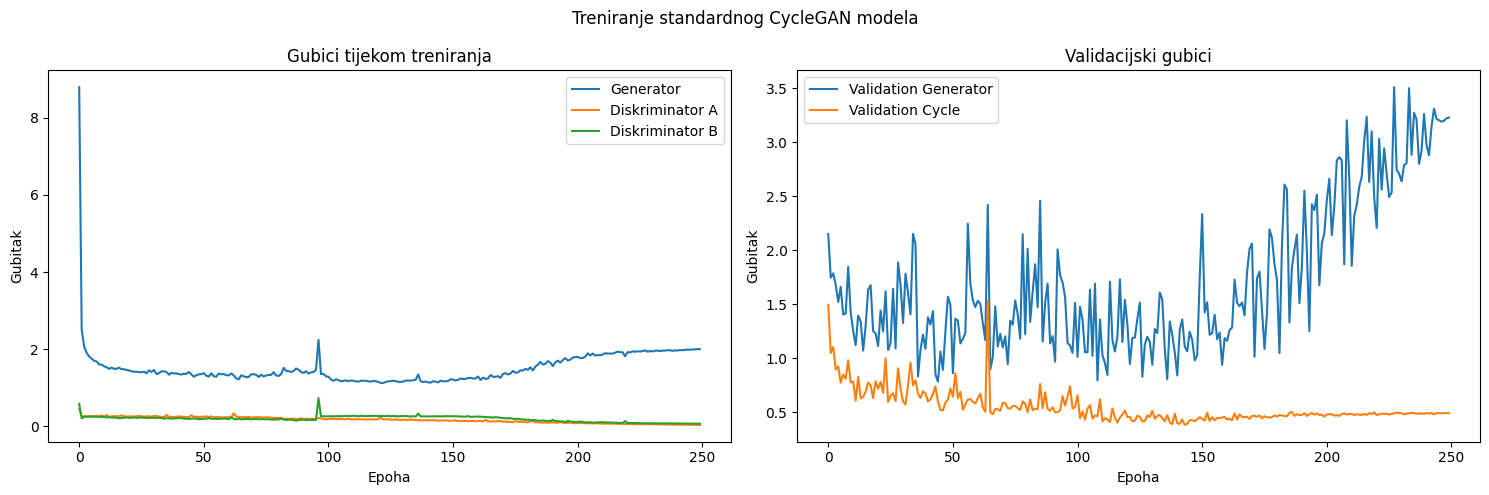

In [24]:
# Vizualizacija krivulja treniranja
plot_training_curves(train_history, "Treniranje standardnog CycleGAN modela")

In [26]:
test_model(G_AB=G_AB, G_BA=G_BA, test_dataloader=test_dataloader, config=config)

Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.88it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8331
  MSE: 0.003395
  PSNR: 24.97 dB

T2 -> T1 translacija:
  SSIM: 0.8667
  MSE: 0.003228
  PSNR: 25.20 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9497
  MSE: 0.000834
  PSNR: 30.98 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9409
  MSE: 0.000945
  PSNR: 30.44 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7371
  MSE: 0.005607
  PSNR: 22.79 dB

T2 -> T1 translacija:
  SSIM: 0.7856
  MSE: 0.005331
  PSNR: 23.02 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9161
  MSE: 0.001377
  PSNR: 28.80 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9013
  MSE: 0.001561
  PSNR: 28.26 dB


Vizualizacija rezultata na test setu:


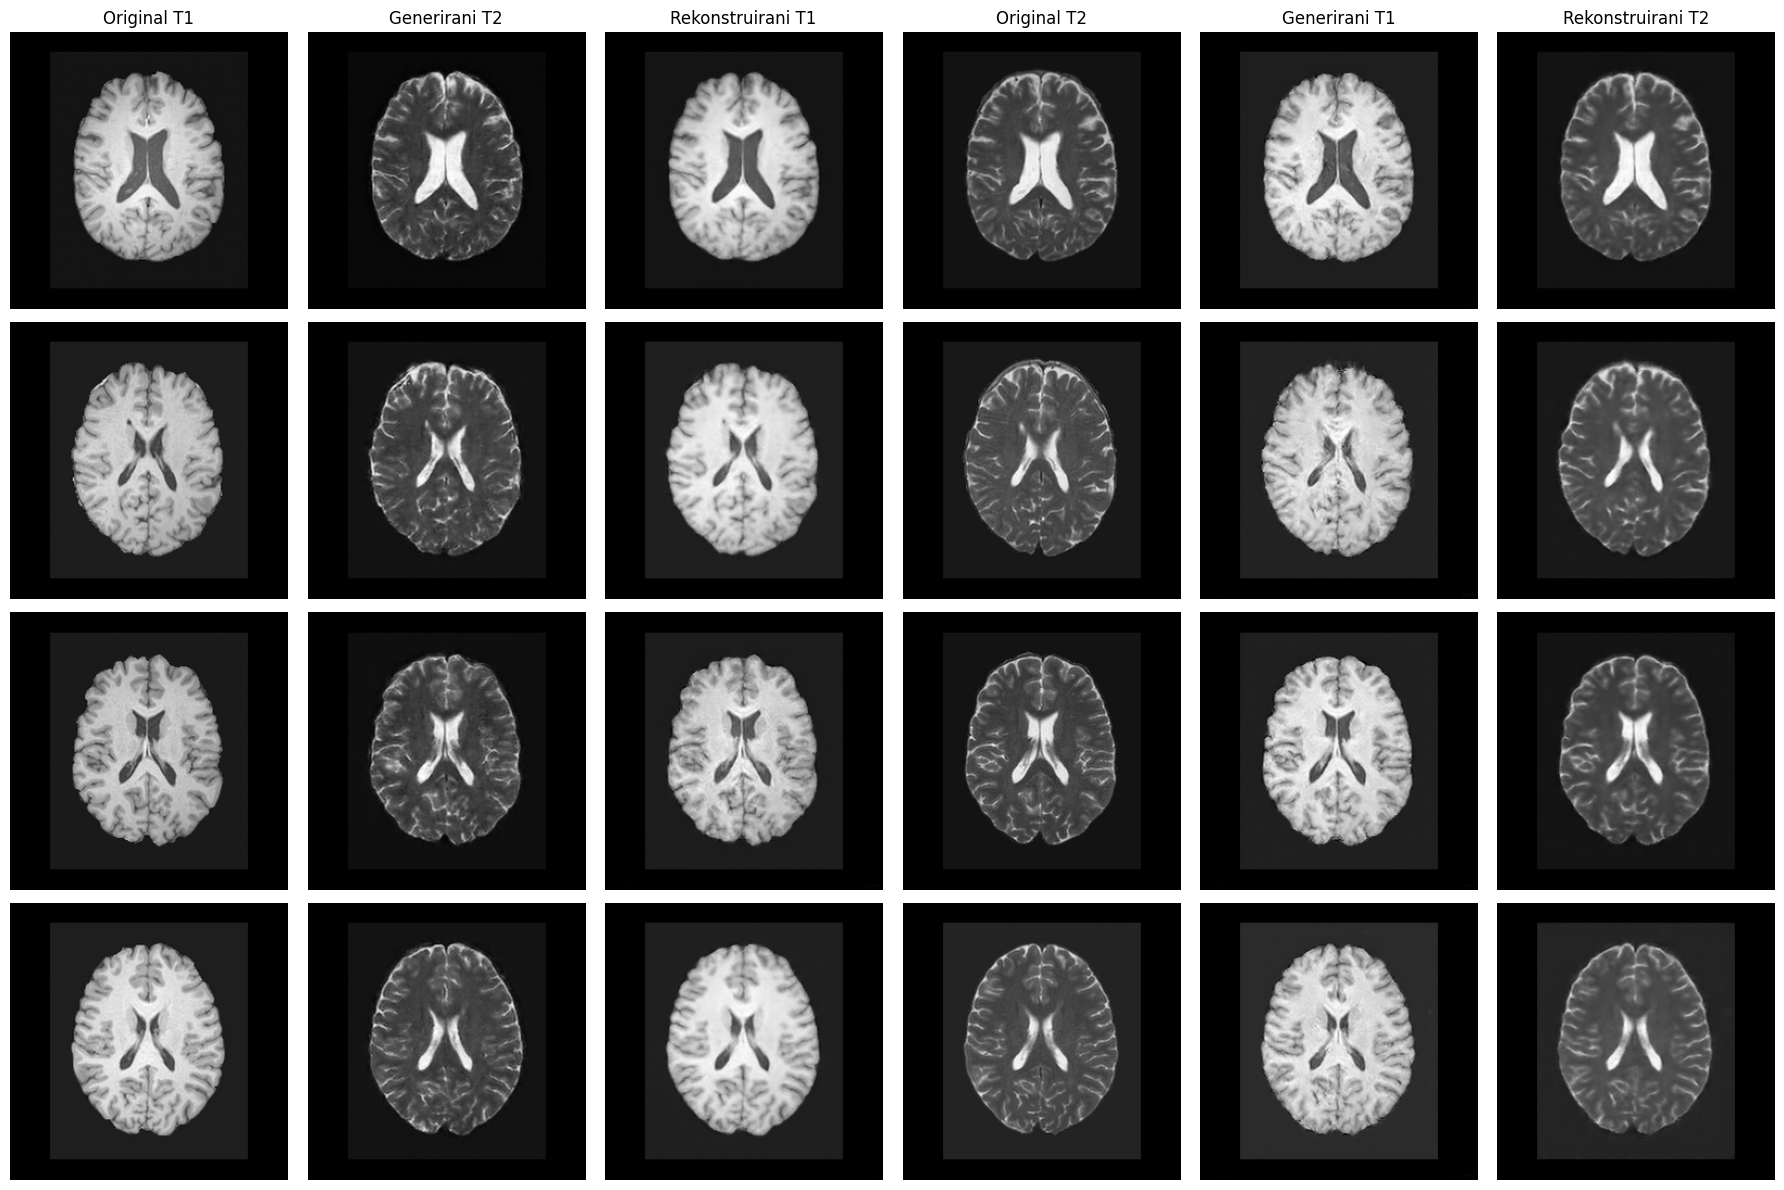

In [28]:
print("Vizualizacija rezultata na test setu:")
visualize_results(G_AB, G_BA, test_dataloader, num_samples=4, config=config)

In [29]:
best_G_AB = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA = UNetGenerator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path = f"{config.checkpoints_dir}/G_AB_best.pth"
best_G_BA_path = f"{config.checkpoints_dir}/G_BA_best.pth"
best_G_AB.load_state_dict(torch.load(best_G_AB_path, map_location=config.device))
best_G_BA.load_state_dict(torch.load(best_G_BA_path, map_location=config.device))

<All keys matched successfully>

In [30]:
print("Testiranje najboljih modela:")
test_model(best_G_AB, best_G_BA, test_dataloader, config)

Testiranje najboljih modela:


Evaluacija modela: 100%|██████████| 22/22 [00:02<00:00,  8.81it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8286
  MSE: 0.003753
  PSNR: 24.53 dB

T2 -> T1 translacija:
  SSIM: 0.8584
  MSE: 0.003383
  PSNR: 24.93 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9792
  MSE: 0.000394
  PSNR: 34.45 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9584
  MSE: 0.000631
  PSNR: 32.13 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7299
  MSE: 0.006199
  PSNR: 22.35 dB

T2 -> T1 translacija:
  SSIM: 0.7705
  MSE: 0.005587
  PSNR: 22.75 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9653
  MSE: 0.000651
  PSNR: 32.27 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9306
  MSE: 0.001042
  PSNR: 29.95 dB


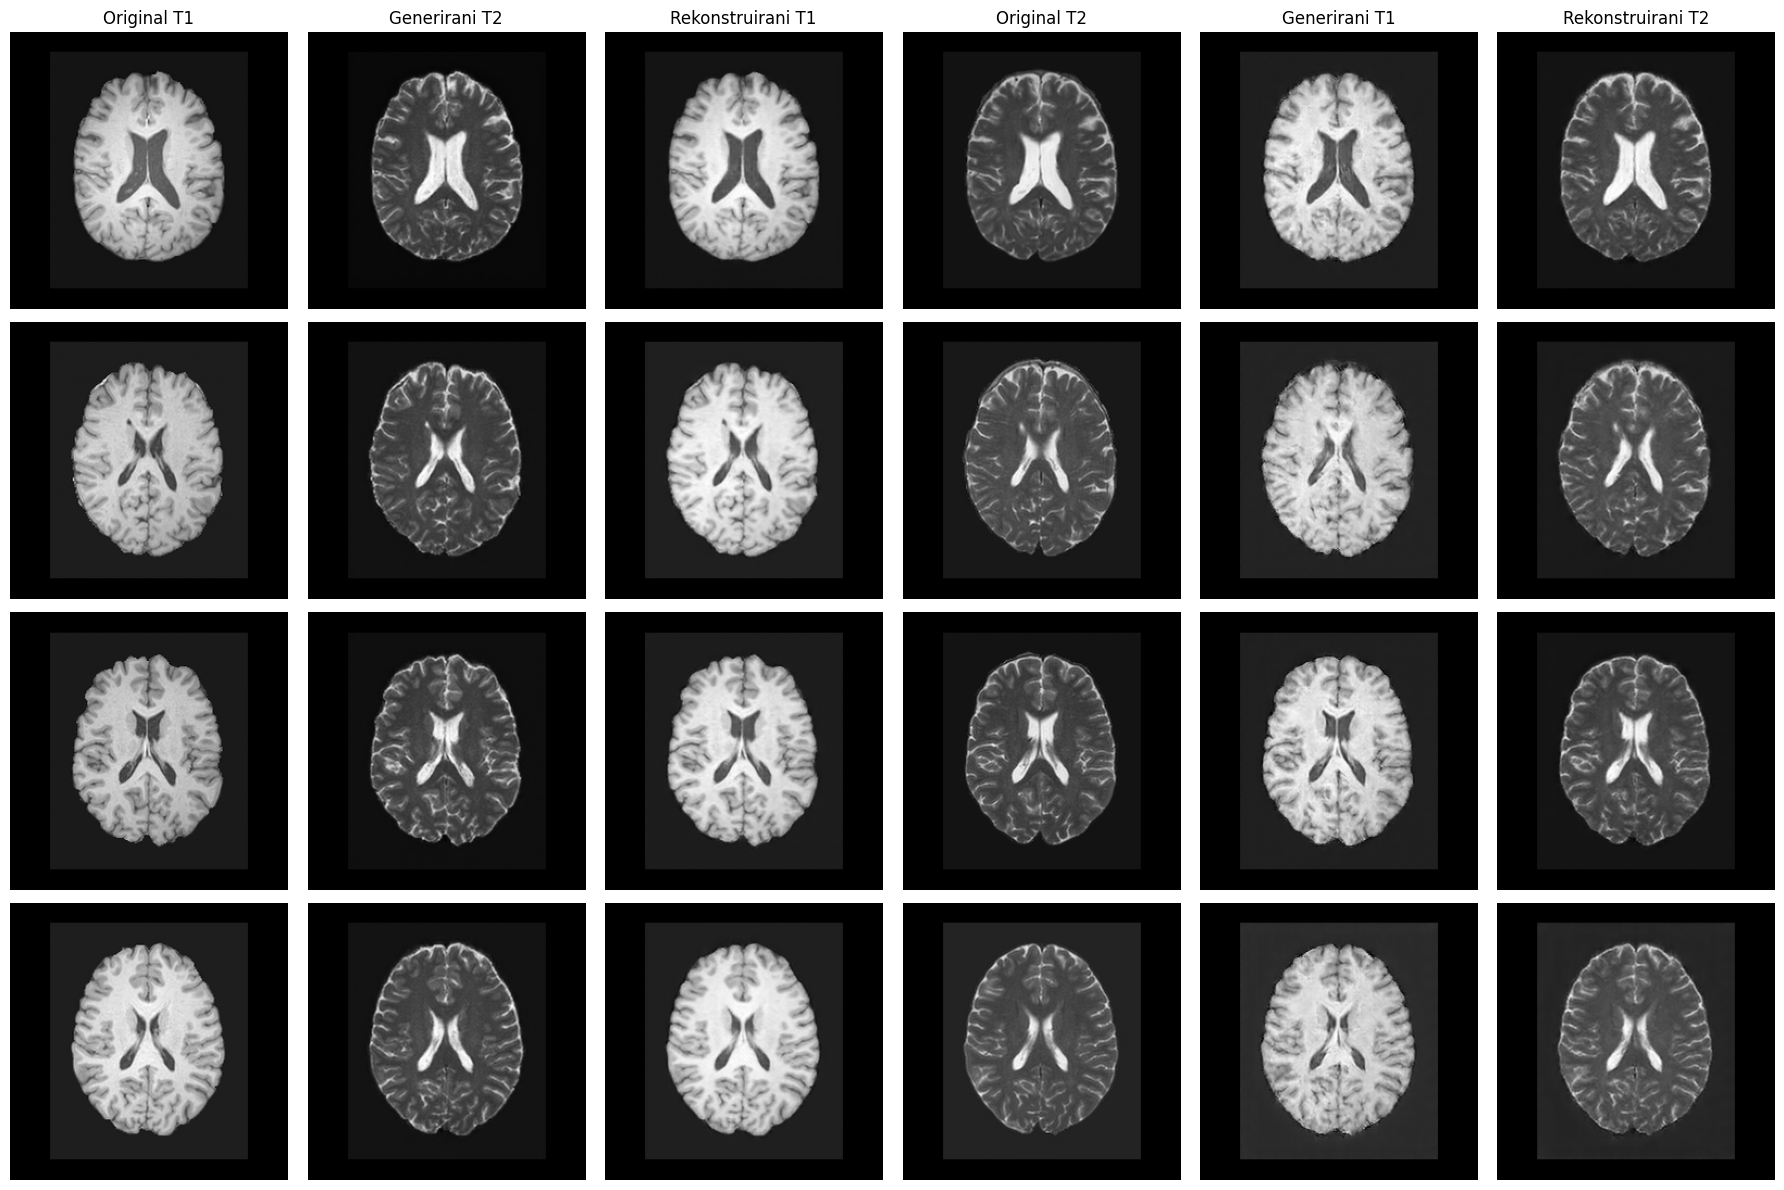

In [31]:
visualize_results(
    best_G_AB, best_G_BA, test_dataloader, num_samples=4, config=config
)